
# Alpha Factor Evaluation

This notebook illustrates the following steps:
- Evaluate the predictive content of your financial features with respect to the 1-day forward returns using several metrics, including:
- the information coefficient (i.e., the Spearman rank correlation)
- the mutual information
- the LightGBM feature importance, computed by training a gradient boosting model with default settings on the first nine years of data 
- SHAP values computed from the LightGBM model (see resources)
- Alphalens quantile-based return spreads (see resources)

These different metrics will yield different and even conflicting answers. Take some time to think about why this is the case, and which approach(es) would likely be most effective when aiming to select the most predictive features?  

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
import shap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [4]:
MONTH = 21
YEAR = 252

## Load Data

In [5]:
DATA_STORE = './data/stock_prices.h5'

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    data = store.get('model_data')

<bound method DataFrame.info of                      ret_01    ret_03    ret_05    ret_10    ret_21    ret_42  \
ticker date                                                                     
A      2006-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
       2006-01-04  0.002687       NaN       NaN       NaN       NaN       NaN   
       2006-01-05  0.026198       NaN       NaN       NaN       NaN       NaN   
       2006-01-06  0.005222  0.034328       NaN       NaN       NaN       NaN   
       2006-01-09 -0.002886  0.028580       NaN       NaN       NaN       NaN   
...                     ...       ...       ...       ...       ...       ...   
ZMH    2015-06-26  0.002560  0.007810  0.007989  0.012121  0.001499 -0.025243   
       2015-06-29  0.000000  0.000352  0.001411  0.016925 -0.004645 -0.013496   
       2015-06-30  0.000000  0.002560  0.007810  0.008974 -0.010543  0.035901   
       2015-07-01  0.000000  0.000000  0.000352  0.009422 -0.005256  0.030367

## Factor Correlation

Which features are most alike in terms of their (rank) correlation?

In [10]:
corr = data.corr(method='spearman')

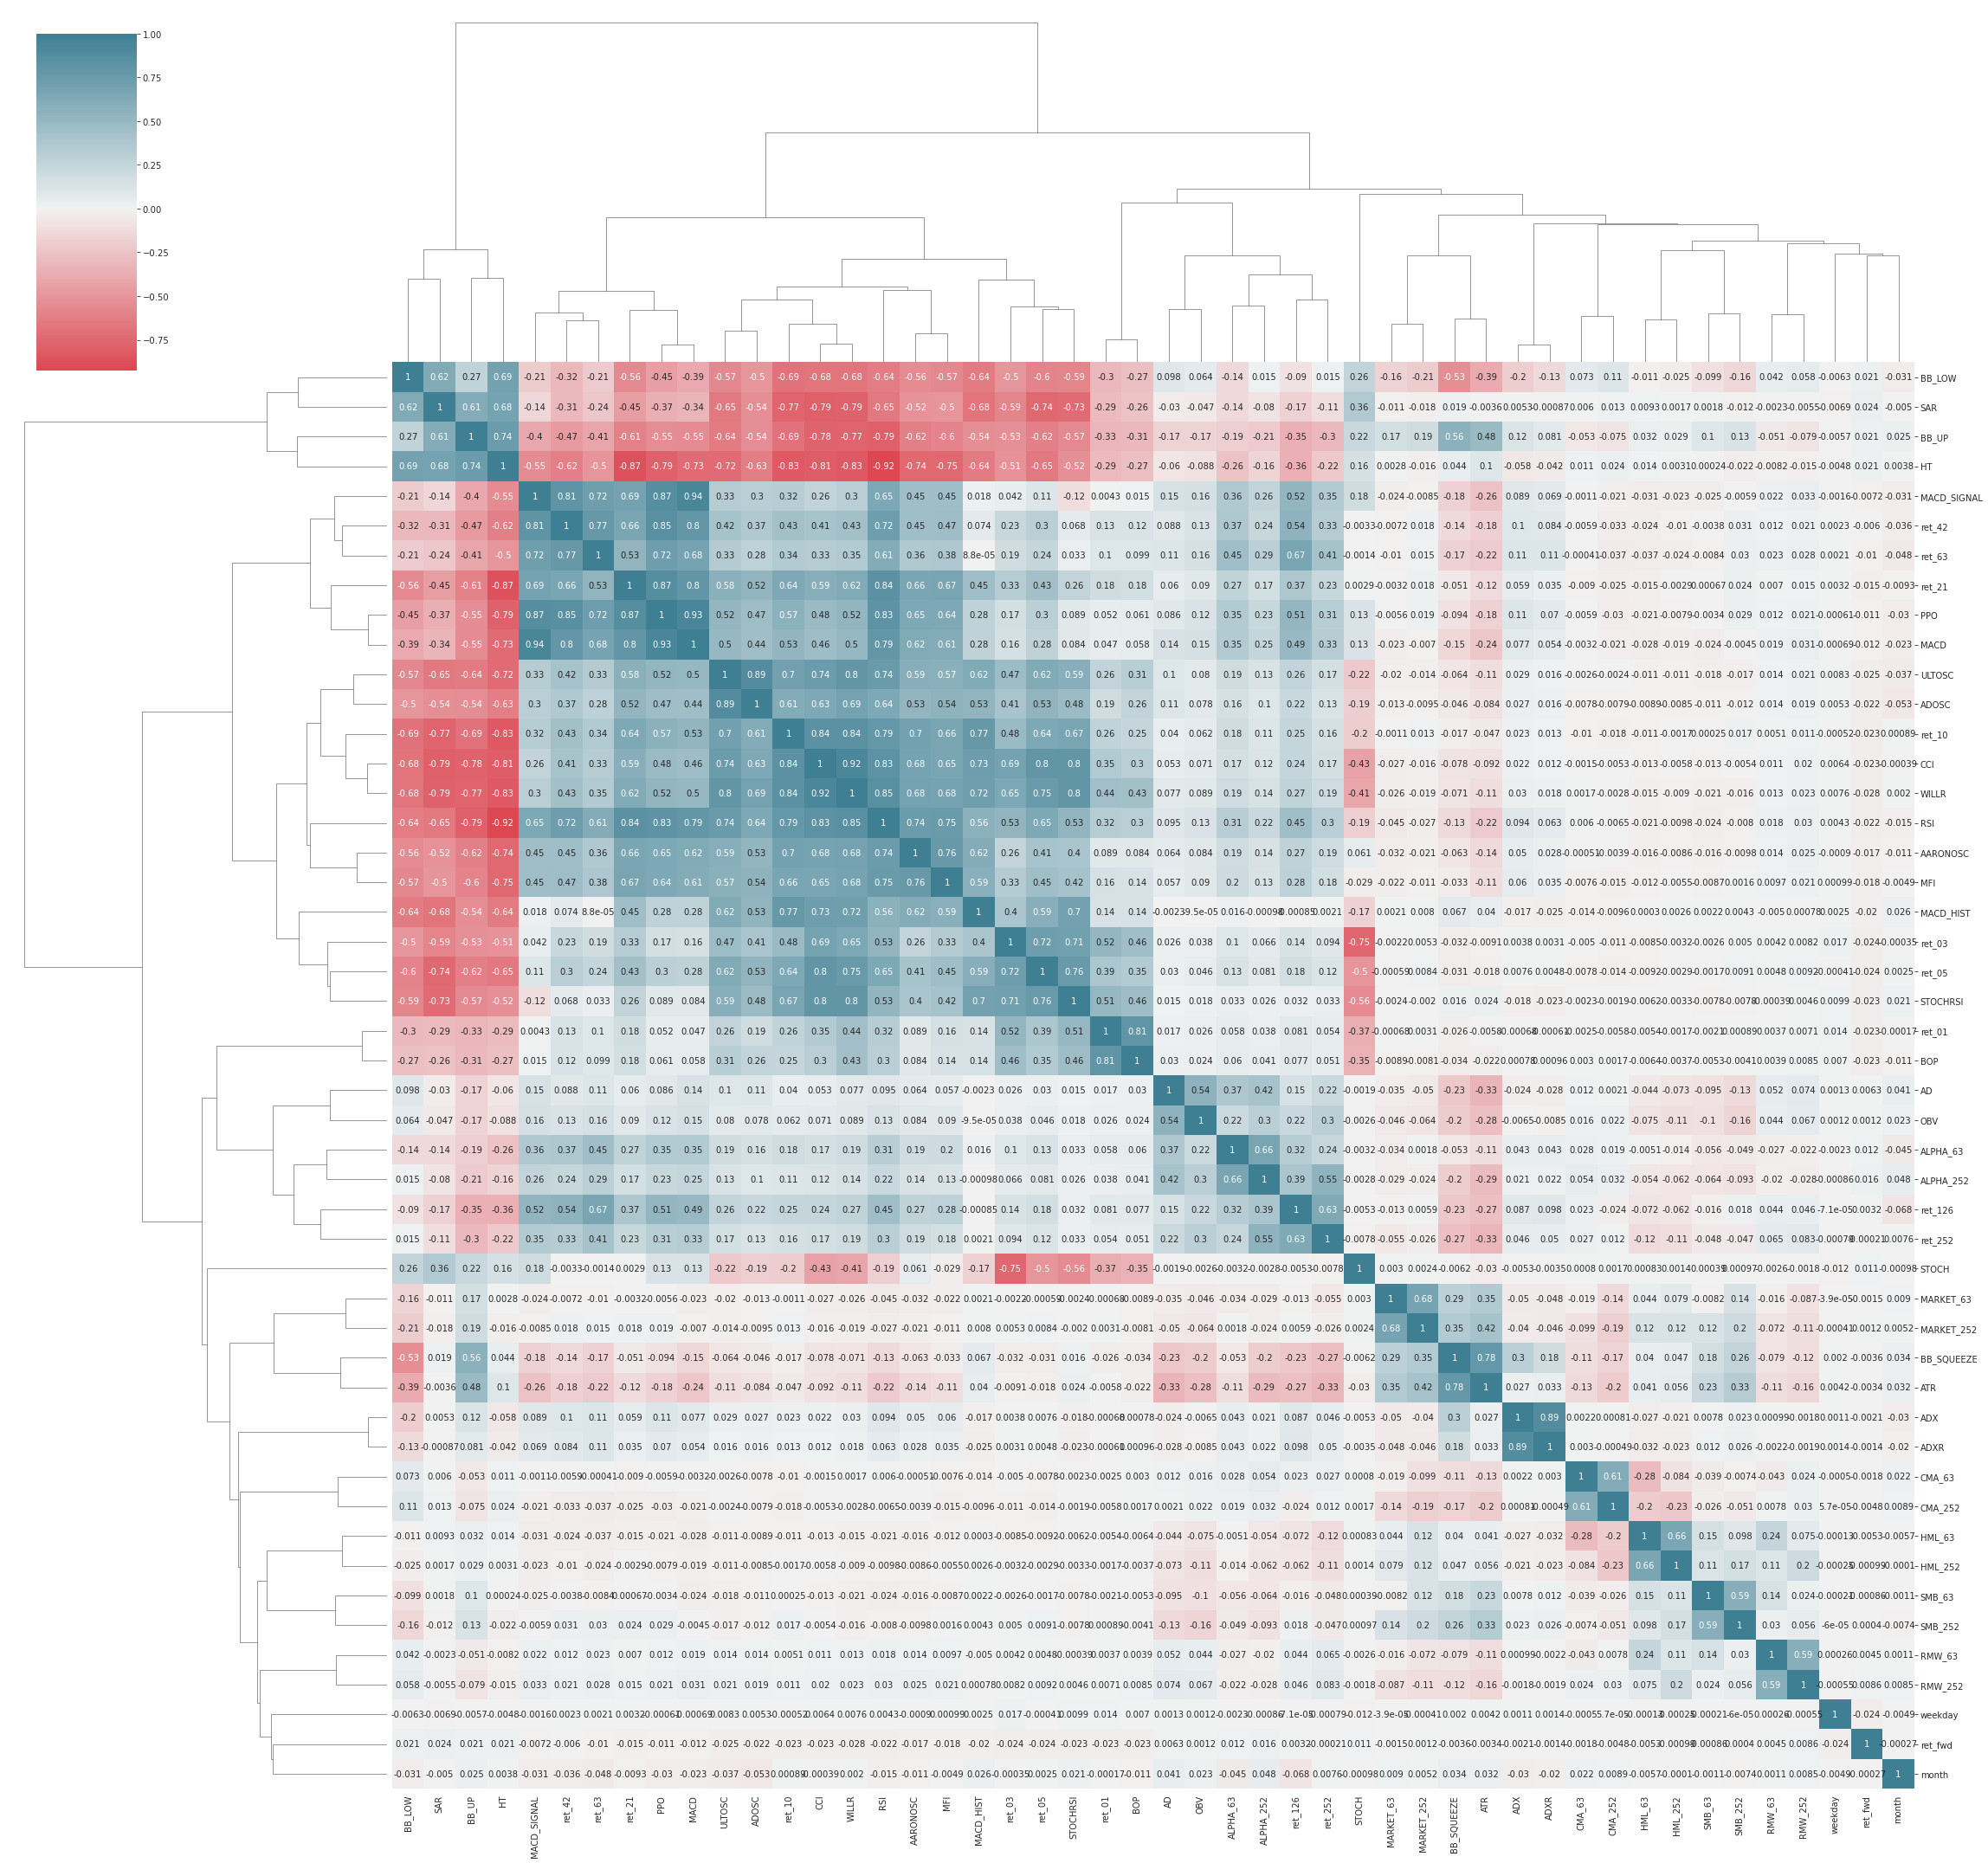

In [14]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(corr, annot=True, cmap=cmap, center=0, figsize=(32, 30))


## Forward return correlation

Which features are most correlated with the forward returns?

In [18]:
corr_fwd = data.corrwith(data['ret_fwd'], method='spearman')

ret_01        -0.023057
ret_03        -0.024110
ret_05        -0.023569
ret_10        -0.022872
ret_21        -0.014608
ret_42        -0.006023
ret_63        -0.010428
ret_126        0.003168
ret_252       -0.000210
ret_fwd        1.000000
BB_UP          0.021202
BB_LOW         0.021478
BB_SQUEEZE    -0.003613
HT             0.020651
SAR            0.024123
ADX           -0.002063
ADXR          -0.001389
PPO           -0.010932
AARONOSC      -0.017116
BOP           -0.022915
CCI           -0.022559
MACD          -0.012238
MACD_SIGNAL   -0.007224
MACD_HIST     -0.019517
MFI           -0.018309
RSI           -0.022211
STOCHRSI      -0.023396
STOCH          0.011446
ULTOSC        -0.025330
WILLR         -0.027891
AD             0.006285
ADOSC         -0.022177
OBV            0.001173
ATR           -0.003401
ALPHA_63       0.011677
MARKET_63     -0.001531
SMB_63        -0.000856
HML_63        -0.005283
RMW_63         0.004502
CMA_63        -0.001846
ALPHA_252      0.016281
MARKET_252     0

In [21]:
corr_fwd.sort_values(ascending=False).head()

ret_fwd    1.000000
SAR        0.024123
BB_LOW     0.021478
BB_UP      0.021202
HT         0.020651
dtype: float64

## Mutual Information

Let's estimate the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between each feature and the forward returns for a non-linear measure of dependency (see scikit-learn [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) for references on computation.

> The `mutual_info_regression` can take a while, reduce the sample size as indicated below to speed up things.

In [61]:
pdata = data.fillna(0)
tgt = pdata['ret_fwd']
pdata.drop('ret_fwd', axis=1, inplace=True)
mi = mutual_info_regression(pdata,tgt, n_neighbors=45)
mi

array([0.0420448 , 0.04220604, 0.04248244, 0.04409621, 0.04667699,
       0.0490823 , 0.0517762 , 0.05770136, 0.05643022, 0.05851444,
       0.02642212, 0.08087831, 0.04545923, 0.06432204, 0.00155965,
       0.00176791, 0.04953481, 0.00869477, 0.00267908, 0.00765161,
       0.0159002 , 0.01538491, 0.00370983, 0.00657069, 0.01618215,
       0.00158675, 0.0041052 , 0.00627237, 0.00863428, 0.01775886,
       0.00399808, 0.01263243, 0.13244647, 0.02833181, 0.01857782,
       0.01410127, 0.01169234, 0.01450655, 0.01364361, 0.04844183,
       0.0222536 , 0.01948505, 0.01331902, 0.01584662, 0.01498859,
       0.00890672, 0.00871378])

In [62]:
max(mi)

0.13244647489709216

<Figure size 3600x1440 with 0 Axes>

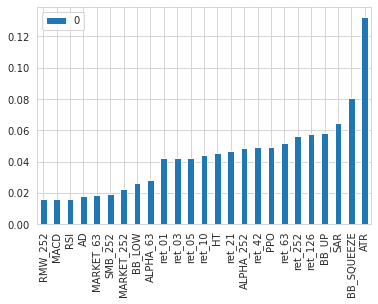

In [63]:
pltdata = pd.DataFrame(data=mi, index=pdata.columns)
pltdata.transpose()
pltdata.head()

plt.figure(figsize=(50, 20))
#plt.bar([col for col in pdata.columns], mi)
pltdata.nlargest(25, 0).sort_values(by=0).plot.bar()
plt.show()

## LightGBM Feature Importance

There will be more information on using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) in Milestone 3.

### Custom Time-Series Cross-Validation

See an example of how the `MultipleTimeSeriesCV` generates sequential, overlapping time periods for training and test in cells 11-13 [here](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/07_linear_models/05_predicting_stock_returns_with_linear_regression.ipynb).

In [40]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        """Generate the positional indices for the train-test splits for each fold"""
        unique_dates = X.index.get_level_values(self.date_idx).unique() # get unique dates
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            # create train/test start and end indices
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


### Custom Metric for Early Stopping

We can customize how LightGBM measures cross-validation progress, and will use the information coefficient. See LightGBM [docs](https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py).

> Keep in mind that early-stopping introduces lookahead bias, so do not use this to select between different model.

In [42]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True # whether to maximize or minimize the metric
    metric_name = 'ic'
    ic = spearmanr(preds, train_data.get_label())[0]
    return metric_name, ic, is_higher_better 

### CV Parameters

In [43]:
categoricals = ['month', 'weekday']

In [44]:
train_length = 9 * YEAR
test_length = YEAR
n_splits = 1

In [45]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              learning_rate=0.01,
#               device='gpu', # uncomment if using GPU
#               max_bins=63,  # uncomment if using GPU
              metric='None')

In [46]:
num_boost_round = 5000

### Create binary Datasets

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html#lightgbm.Dataset) on the `lgb.Dataset`.

In [47]:
lgb_data = lgb.Dataset(data=factors.loc[:, features],
                       label=factors[fwd_returns],
                       categorical_feature=categoricals,
                       free_raw_data=False)

In [48]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

### Cross-validation loop

In [50]:
for train_idx, test_idx in cv.split(X=factors):
    start = time()
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      evals_result=evals_result,
                      early_stopping_rounds=500,
                      verbose_eval=100)
    model.save_model('lgb_model.txt')

Training until validation scores don't improve for 500 rounds
[100]	train's ic: 0.103316	valid's ic: 0.0258415
[200]	train's ic: 0.134473	valid's ic: 0.0277474
[300]	train's ic: 0.148486	valid's ic: 0.0343945
[400]	train's ic: 0.162671	valid's ic: 0.0365906
[500]	train's ic: 0.179014	valid's ic: 0.0384288
[600]	train's ic: 0.189967	valid's ic: 0.0372857
[700]	train's ic: 0.200772	valid's ic: 0.035115
[800]	train's ic: 0.206793	valid's ic: 0.0328009
[900]	train's ic: 0.21175	valid's ic: 0.031564
[1000]	train's ic: 0.216116	valid's ic: 0.0312372
Early stopping, best iteration is:
[547]	train's ic: 0.184552	valid's ic: 0.0388062


We can persist the model to generate predictions later:

In [ ]:
model = lgb.Booster(model_file='lgb_model.txt')

### Generate and evaluate predictions

In [52]:
# select test features and label
test_set = factors.iloc[test_idx, :]
X_test = test_set.loc[:, model.feature_name()]
y_test = test_set.loc[:, fwd_returns[0]]

# make predictions
y_pred = model.predict(X_test)
cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)

# compute daily correlation
by_day = cv_preds.groupby(level='date')
ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
daily_ic_mean = ic_by_day.mean()
daily_ic_std = ic_by_day.std()
daily_ic_median = ic_by_day.median()
ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
print(f'Overall IC: {ic:6.2%} | Average Daily IC: {daily_ic_mean: 6.2%} | Coefficient of Variation for daily IC: {daily_ic_std/daily_ic_mean: 5.2} | Median Daily IC: {daily_ic_median: 6.2%}')

Overall IC:  3.88% | Average Daily IC:  2.80% | Coefficient of Variation for daily IC:   5.6 | Median Daily IC:  1.77%


While the daily average of the IC is positive at 0.028, it is also quite volatile. In other words, predictions will do quite poorly occasionally (and much better otherwise).

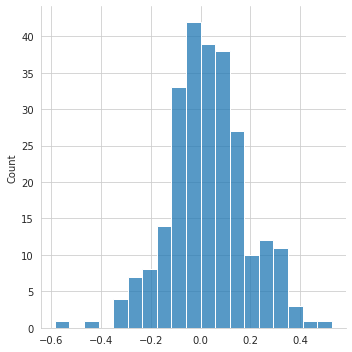

In [55]:
sns.displot(ic_by_day);

Higher momemts (Skew and Kurtosis) confirm that, while only slightly negatively skewed, but has significantly fatter tails than a normal distribution (pandas uses [Fisher's definition](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.kurtosis.html)).

In [61]:
pd.Series({'Mean': ic_by_day.mean(), 
           'Std. Dev': ic_by_day.std(), 
           'Median': ic_by_day.median(), 
           'Skew': ic_by_day.skew(), 
           'Kurtosis': ic_by_day.kurtosis()}).apply(lambda x: f'{x:.4f}')

Mean         0.0280
Std. Dev     0.1581
Median       0.0177
Skew        -0.0603
Kurtosis     0.9252
dtype: object

### Compute Feature Importance

In [62]:
def get_fi(model):
    """Compute LightGBM feature imporance"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [63]:
fi = get_fi(model)
fi.to_csv('feature_importance.csv')

In [64]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'], 
                          'Validation Set': evals_result['valid']['ic']})

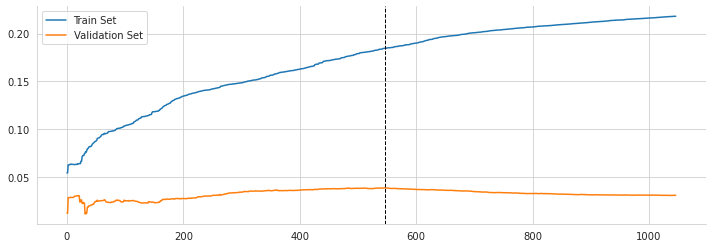

In [65]:
ax = cv_result.plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)
sns.despine();

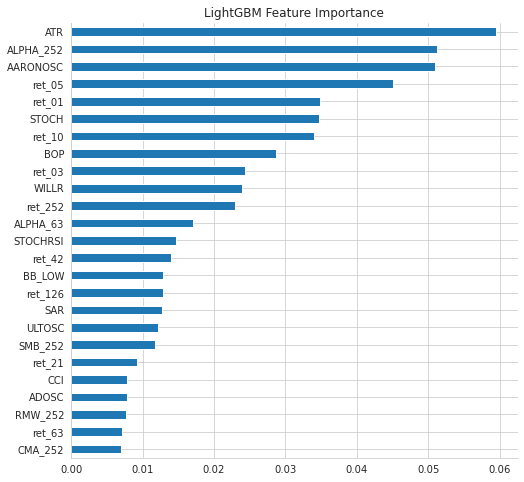

In [66]:
fi.drop(categoricals).nlargest(25).sort_values().plot.barh(figsize=(8, 8),
                                        title='LightGBM Feature Importance')
sns.despine();

## SHAP Values

See SHAP Values [GitHub repo](https://github.com/slundberg/shap) for docs and links to papers.

In [67]:
shap.initjs()

In [68]:
model = lgb.Booster(model_file='lgb_model.txt')

In [69]:
explainer = shap.TreeExplainer(model)

In [70]:
# workaround for SHAP version 0.35: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [71]:
shap_values = explainer.shap_values(factors.iloc[test_idx, :].loc[:, model.feature_name()])

In [72]:
np.save('shap_values.npy', shap_values)

In [73]:
shap_values = np.load('shap_values.npy')

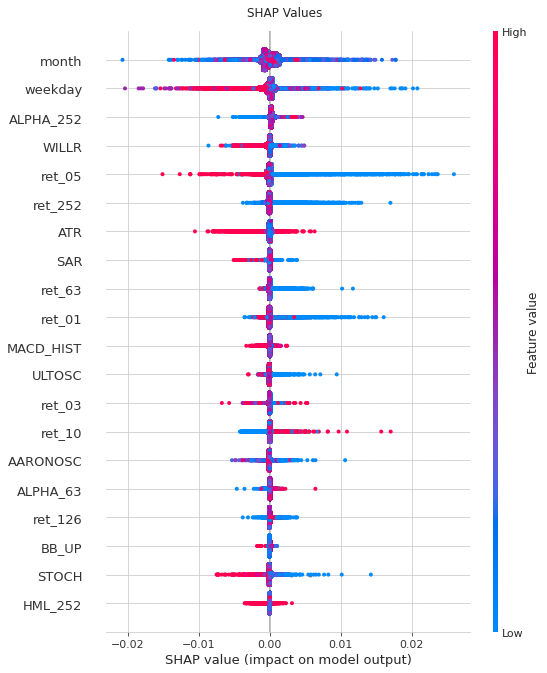

In [74]:
shap.summary_plot(shap_values,
                  factors
                  .iloc[test_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)

plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()

In [75]:
shap_values = pd.DataFrame(shap_values, columns=features)

In [76]:
shap_summary = np.abs(shap_values).mean()
shap_summary /= shap_summary.sum()

In [77]:
shap_summary.nlargest(20)

month        0.249420
weekday      0.154410
ALPHA_252    0.086554
WILLR        0.055753
ret_05       0.048793
ret_252      0.047245
ATR          0.040661
SAR          0.028278
ret_63       0.024310
ret_01       0.021219
MACD_HIST    0.019825
ULTOSC       0.018464
ret_03       0.018118
ret_10       0.017536
AARONOSC     0.016159
ALPHA_63     0.015013
ret_126      0.014518
BB_UP        0.013611
STOCH        0.010562
HML_252      0.010176
dtype: float64

In [78]:
shap_summary.to_csv('shap_values.csv')

## Comparison

In [79]:
mi = pd.read_csv('mutual_info.csv', index_col=0, squeeze=True)
fwd_corr = pd.read_csv('forward_correlation.csv', index_col=0, squeeze=True)

In [80]:
stats = (mi.to_frame('Mutual Information')
         .join(fwd_corr.to_frame('Information Coefficient'))
         .join(fi.to_frame('Feature Importance'))
         .join(shap_summary.to_frame('SHAP Values')))

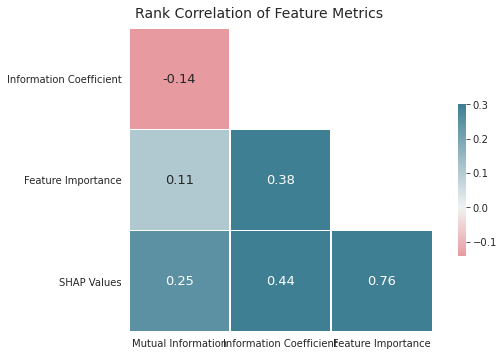

In [81]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}

corr = stats.assign(**cols).corr('spearman')

mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask,
            cmap=cmap,
            vmax=.3, center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True, fmt='.2f',
            annot_kws={"size": 13})

plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.92)

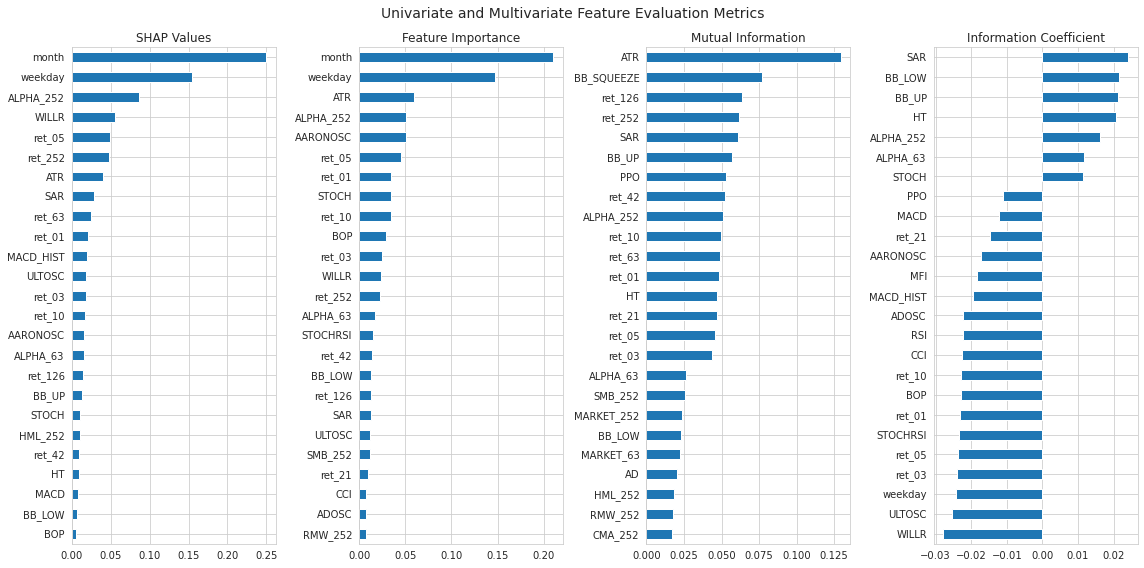

In [82]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')

fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')

mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91);

In [83]:
top_ranked = stats.drop('Mutual Information', axis=1).abs().rank(ascending=False).mean(1)

In [84]:
top_ranked.to_csv('top_features.csv')

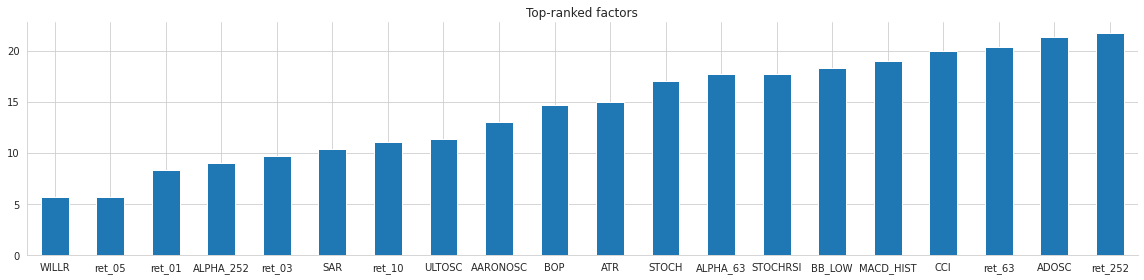

In [85]:
top_ranked.drop(categoricals).nsmallest(20).plot.bar(figsize=(16, 4), rot=0, title='Top-ranked factors')
sns.despine()
plt.tight_layout();

## Alphalens Analysis

Alphalens is a Python Library (originally developed by Quantopian) for performance analysis of predictive (alpha) stock factors. Alphalens works great with the Zipline open source backtesting library, and Pyfolio which provides performance and risk analysis of financial portfolios. 

The main function of Alphalens is to surface the most relevant statistics and plots about an alpha factor, including:

- Returns Analysis
- Information Coefficient Analysis
- Turnover Analysis
- Grouped Analysis

See Alphalens [docs](https://alphalens.ml4trading.io) and [example notebooks](https://github.com/stefan-jansen/alphalens-reloaded/tree/master/alphalens/examples) for additional detail.

In [86]:
tickers = factors.index.unique('ticker')

### Get trade prices

We need market prices for the relevant period:

In [87]:
def get_trade_prices(tickers):
    return (pd.read_hdf(DATA_STORE, 'us_stocks')
              .loc[idx[tickers, '2006':'2017'], 'open']
              .unstack('ticker')
              .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [88]:
trade_prices = get_trade_prices(tickers)

In [89]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 500 entries, A to ZMH
dtypes: float64(500)
memory usage: 11.5 MB


### Select factor

We also need the factor signals that we want to evaluate:

In [90]:
alpha = 'ATR'

In [91]:
factor = (factors[alpha]
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())

### Generate Alphalens input data

With a signal and pricing data creating a factor "tear sheet" is a two step process:
1. Bring data into the right format
2. Select desired tearsheet.

In [92]:
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor,d
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   max_loss=0.35,
                                                   periods=(1, 5, 10)).sort_index()
factor_data.info()

Dropped 2.7% entries from factor data: 2.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1358061 entries, (Timestamp('2006-01-23 00:00:00+0000', tz='UTC', freq='C'), 'A') to (Timestamp('2016-12-29 00:00:00+0000', tz='UTC', freq='C'), 'ZION')
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   1D               1358061 non-null  float64
 1   5D               1358061 non-null  float64
 2   11D              1358061 non-null  float64
 3   factor           1358061 non-null  float64
 4   factor_quantile  1358061 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 57.1+ MB


### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000081,0.076998,0.017367,0.008179,272203,20.043503
2,0.011363,0.092474,0.022592,0.010599,271404,19.984669
3,0.013188,0.109139,0.027144,0.013145,271143,19.965451
4,0.015607,0.139410,0.032996,0.016438,271404,19.984669
5,0.019018,1.141389,0.048438,0.030306,271907,20.021707


Returns Analysis


,1D,5D,11D
Ann. alpha,-0.029,-0.032,-0.030
beta,0.511,0.546,0.540
Mean Period Wise Return Top Quantile (bps),2.017,1.798,1.447
Mean Period Wise Return Bottom Quantile (bps),-1.439,-1.372,-1.205
Mean Period Wise Spread (bps),3.456,2.963,2.462


Information Analysis


,1D,5D,11D
IC Mean,-0.012,-0.007,-0.003
IC Std.,0.256,0.263,0.252
Risk-Adjusted IC,-0.046,-0.025,-0.012
t-stat(IC),-2.396,-1.331,-0.649
p-value(IC),0.017,0.183,0.516
IC Skew,-0.079,-0.100,-0.098
IC Kurtosis,-0.277,-0.444,-0.366


Turnover Analysis


,1D,5D,11D
Quantile 1 Mean Turnover,0.048,0.126,0.186
Quantile 2 Mean Turnover,0.109,0.280,0.400
Quantile 3 Mean Turnover,0.121,0.311,0.438
Quantile 4 Mean Turnover,0.099,0.261,0.377
Quantile 5 Mean Turnover,0.040,0.107,0.160


,1D,5D,11D
Mean Factor Rank Autocorrelation,0.995,0.97,0.939


<Figure size 432x288 with 0 Axes>

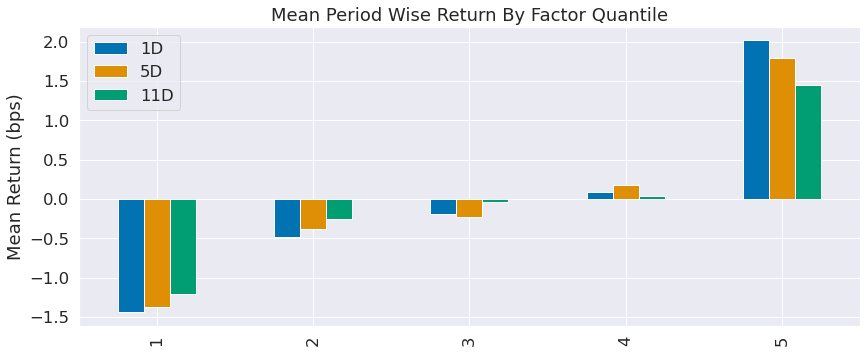

In [93]:
create_summary_tear_sheet(factor_data)